For this part of the homework, we will work with a subset of the CalTech-256 dataset, a widely recognized image dataset comprising a diverse collection of 256 object categories. This subset contains 10 specific classes from the CalTech-256 dataset. Your first task is to review the images in this dataset and compare how the classification task for this dataset differs from the other two datasets in this homework. You will then need to adjust and execute the code to observe how a Convolutional Neural Network (CNN) trained from scratch performs in comparison to a fine-tuned VGG16 model when applied to this specific dataset. Furthermore, you should evaluate and compare the performance of the two models on both the CalTech-256 dataset and the other dataset.

For the coding task, your main objectives are as follows:

+ Modify the data preprocessing functions, dataset class, and data loaders to be compatible with the CalTech-256 dataset. Please be aware that, unlike the HAM10000 dataset, the CalTech-256 dataset contains images of varying sizes.

+ Modify the existing model architecture and the VGG16 model to work with this dataset.

# Download Dataset
+ Download dataset from Box
+ (You can download the images to your desktop by using the link https://ucsb.box.com/shared/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip)
+ unzip dataset

In [1]:
!wget -nc -O datasets.zip https://ucsb.box.com/shared/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip

File ‘datasets.zip’ already there; not retrieving.


In [2]:
!unzip -n datasets.zip

Archive:  datasets.zip


# Import libraries

In [4]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import pandas as pd
from typing import Dict, Final, List, Tuple, NamedTuple, Type, Union
from tqdm.auto import tqdm, trange
import torch
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

from PIL import Image

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)


PyTorch Version:  2.5.1
Torchvision Version:  0.20.1


# Type Definition
Define some types for clearer labeling of our interfaces.

In [5]:
TODO = NotImplemented  # NOTE: This is a placeholder for code that needs to be written

Loss: Type = float
Accuracy: Type = float


class LossAcc(NamedTuple):
    loss: Loss
    accuracy: Accuracy


class TrainValLossAcc(NamedTuple):
    train: List[List[LossAcc]]
    val: List[LossAcc]


example_result_pair: LossAcc = LossAcc(1.6, 0.7)
print("loss:", example_result_pair.loss)
print("accuracy:", example_result_pair.accuracy)
print(example_result_pair)

loss: 1.6
accuracy: 0.7
LossAcc(loss=1.6, accuracy=0.7)


# Configurations
Some configuration options that are required to make the dataset work with PyTorch.

In [6]:
num_epochs: Final[int] = 20

batch_size: Final[int] = 16

valid_set_size: Final[float] = 0.30

print("Number of epochs: ", num_epochs)
print("Batch size: ", batch_size)


Number of epochs:  20
Batch size:  16


# Loading CalTech-256 training data from directory

1. Define Data Transforms:

  + Define data transformations using `transforms.Compose`. This should include
    + Padding to make the image a square.
    + Conversion to a tensor. Converts a PIL Image or numpy.ndarray (H x W x C) in the range `[0, 255]` to a torch.FloatTensor of shape (C x H x W) in the range `[0.0, 1.0]`.
    + Resizing to (224, 224).
    + Optionally, you can include other preprocessing steps.
  + Padding is added to maintain the aspect ratio of the image content when resizing to (224, 224).

2. Load the CalTech-256 Dataset:

  + Set the path to your CalTech-256 `train` dataset directory.
  + Create the dataset using the `datasets.ImageFolder` class. This class automatically assigns labels based on the subdirectory names.

3. Get Class Labels:

  + Obtain the class labels (class names) from the `all_dataset.classes` attribute. This will give you a list of class labels in the order they appear in the dataset.


In [7]:
# Define a custom data transform to pad the image to be square
class SquarePad(object):
    def __init__(self, fill_color=(0, 0, 0)):
        self.fill_color = fill_color

    def __call__(self, img):
        width, height = img.size

        # Calculate the size of the square canvas
        size = max(width, height)

        # Create a new blank image with the square size
        new_img = Image.new('RGB', (size, size), self.fill_color)

        # Paste the original image onto the center of the square canvas
        new_img.paste(img, ((size - width) // 2, (size - height) // 2))

        return new_img

In [9]:
# Define the data transformations composing of
# - Padding to make the image a square
# - Conversion to a tensor
# - Resize to size (224, 224)
# Compose: https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
data_transforms = transforms.Compose([
    transforms.Pad((0, 0, 0, 0), fill=0),  # Padding to make image a square (optional adjustment for image size)
    transforms.ToTensor(),                # Convert to tensor
    transforms.Resize((224, 224))         # Resize to 224x224
    # You can add more transformations as needed, e.g., normalization
])

# Set the path to your CalTech-256 train dataset directory
data_dir = './datasets/CalTech-256/train'

# Create a dataset using ImageFolder
# ImageFolder: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
all_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# get the classes attribute from all_dataset
classes: Final[List[str]] = all_dataset.classes

num_classes: Final[int] = len(classes)
print(f'Number of classes: {len(classes)}')

Number of classes: 10


PyTorch provides the `torch.utils.data.random_split()` function to split a dataset. This method takes a dataset and a list of lengths/ratios, and returns a list of datasets of the specified lengths/ratios. If lengths are given, the sum of the lengths must equal the length of the original dataset. If ratios are given, the sum of the ratios must equal to 1. In the configuration block above, we have already computed `test_set_sample_count` and `test_set_actual_size` for you, so you can use it to create a train/valid split.

To get a consistent split, you are able to set your own random seed, though the process is more complex than for `scikit-learn`. To do so, add the argument `generator=torch.Generator().manual_seed(9)` to the `random_split()` function call. This split has produced a good class balance in our testing, but you are welcome to experiment with different `valid_set_size` and `manual_seed` values.

In [11]:
# random_split: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

dataset_size = len(all_dataset)

valid_size = int(valid_set_size*dataset_size)

train_size = dataset_size-valid_size

generator = torch.Generator().manual_seed(9)

train_dataset, val_dataset = torch.utils.data.random_split(all_dataset, [train_size, valid_size], generator=generator)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 1008
Validation dataset size: 431


Once arranged into a `Dataset`, we wrap the `Dataset` in a `Dataloader` object. This object is used to iterate over the dataset in batches, shuffle the dataset, and perform other useful operations, like parallel data loading.

In [12]:
# DataLoader: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


The below visualization of class label balances is provided for your reference. The train/valid split should produce similar class label balances.

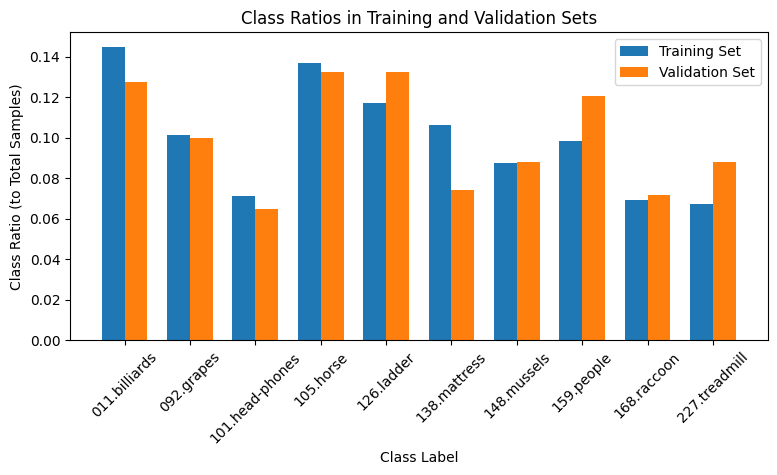

In [13]:
import numpy as np

# Define a function to plot class label distribution as ratios
def plot_class_distribution_ratios(train_dataset, val_dataset):
    class_counts_train = [0] * len(train_dataset.dataset.classes)
    class_counts_val = [0] * len(val_dataset.dataset.classes)

    for _, label in train_dataset:
        class_counts_train[label] += 1

    for _, label in val_dataset:
        class_counts_val[label] += 1

    # Calculate the total number of samples in the entire dataset
    total_train_samples = sum(class_counts_train)
    total_valid_samples = sum(class_counts_val)

    # Calculate class ratios
    class_ratios_train = [count / total_train_samples for count in class_counts_train]
    class_ratios_val = [count / total_valid_samples for count in class_counts_val]

    class_labels = train_dataset.dataset.classes
    width = 0.35
    x = np.arange(len(class_labels))

    plt.figure(figsize=(9, 4))
    plt.bar(x - width/2, class_ratios_train, width, label='Training Set')
    plt.bar(x + width/2, class_ratios_val, width, label='Validation Set')
    plt.xlabel('Class Label')
    plt.ylabel('Class Ratio (to Total Samples)')
    plt.title('Class Ratios in Training and Validation Sets')
    plt.xticks(x, class_labels, rotation=45)
    plt.legend()
    plt.show()

# Plot class ratios for training and validation sets
plot_class_distribution_ratios(train_dataset, val_dataset)

# Custom Neural Network Model

Now we'll define a new network. We'll use this network to train on the CalTech-256 dataset. We'll use the `torch.nn` module to define the network. This module provides a number of useful building blocks for neural networks, including linear layers, convolution layers, dropout layers, maxpooling layers, activation functions, flatten function, and loss functions.

If this is your absolute first interaction with PyTorch, you may find [this basic tutorial link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) and [this CNN tutorial link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) to be of use.

In [14]:
import torch.nn as nn

class CalTechNetwork(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CalTechNetwork, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 14 * 14, 128)  # Adjust the input size based on your needs
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after the first convolutional layer
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout after the second convolutional layer
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout after the third convolutional layer
        x = self.pool(nn.functional.relu(self.conv4(x)))
        x = self.dropout(x)  # Apply dropout after the fourth convolutional layer
        x = x.view(x.size(0), -1)  # Adjust the input size based on your needs
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

# Create an instance of the CalTechNetwork model with dropout
dropout_prob = 0.5  # You can adjust the dropout probability as needed
model = CalTechNetwork(dropout_prob)


# Validate Function

We will define the `validate` function that evaluates the performance of the model after every training epoch. This function simply puts the network into `eval` mode, then iterates over the validation dataset and computes the accuracy and loss of the network.

Accuracy computations you can perform in similar manner as you have in the past assignments. For loss computations, we will use the `torch.nn.functional.cross_entropy` function, which assumes the network outputs class logits, and computes the cross entropy loss between the logits and the ground truth labels.

Some components of models behave differently whether they're under training or validation. For example, dropout layers will randomly drop out nodes during training, but will not do so during validation. To handle this, PyTorch provides the `.train()` method to set the model into training mode and the `.eval()` method to set the model into validation mode. We will use this to set the model into validation mode before computing the accuracy and loss.

Running data through a model is as simple as treating the model as a function! That is, `model(data)` will run the data through the model and return the output. We can then use this output to compute the accuracy and loss.

The result of `torch.tensor` computations is always more `torch.tensor`s, so use the `.item()` method to get the actual value of the loss and/or accuracy when you are ready to store it.

To leverage a GPU for speeding up the computation, you should move the model, data, and labels to the GPU when a GPU is available.

In [16]:
def validate(model: nn.Module, val_data: DataLoader) -> LossAcc:
    """
    Returns the loss and accuracy of the model on the validation data.
    """
    # Check for GPU availability:
    # This code assigns the GPU ("cuda") as the device if a GPU is available;
    # otherwise, it defaults to the CPU.
    # Hint: search for `torch.device` and `torch.cuda.is_available`
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
    elif (torch.mps.is_available()):
        device = torch.device('mps')
    else:
        device = torch.device("cpu")

    # Move the model to the GPU using the `.to` method
    # CODE HERE (One line)
    model.to(device)# Provided

    # Set model to evaluation mode
    model.eval()

    # The below line sets up an environment that prevents
    # the model from updating its weights during validation.
    # This is helpful because we don't want to update the weights,
    # so using this line saves us expensive gradient computations.
    with torch.no_grad():
        # Set up any tracking variables you'd like to use in order to compute
        # the accuracy and average loss over all batches
        total_loss = 0.0
        correct_preductions = 0
        total_samples = 0

        # Iterate through the batches of validation data
        # CODE HERE
        for batch in val_data:# Provided

            # Get the data and labels from the batch
            data,labels = batch

            # Move the data and labels to the GPU using the `.to` method
            data, labels = data.to(device), labels.to(device)

            # Get the model's predictions for the data
            outputs = model(data)

            # Calculate the average loss of this batch
            # using `nn.functional.cross_entropy`
            loss = nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()

            # Calculate the number of correct predictions and
            # retrieve the number of samples in this batch
            _, predicted = torch.max(outputs,1)
            correct_preductions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Compute the accuracy and average loss over all batches.
        accuracy = correct_preductions/total_samples
        average_loss = total_loss / len(val_data)

        return LossAcc(loss=average_loss, accuracy=accuracy)

# Training Functions
Now, to train a model, we have to write training functions. To ease understanding, we've broken the writing of a "training loop" into three functions: `train_batch` to handle a single batch, `train_epoch` to handle a single epoch, and `train_loop` to handle training as many steps as you would like.

Remember, we're still using `nn.functional.cross_entropy` to compute the loss. Don't forget to set the model to `.train()` mode before training!

After setting the model to training, we need to zero out the gradients from the previous step. This is because PyTorch accumulates gradients from each step, and we don't want to accumulate multiple steps of gradients after we've already used their gradients to update the model. We can zero out the gradients by calling the `.zero_grad()` method on the optimizer. Once we've computed the loss, we can call the `.backward()` method on the loss to compute the gradients. Finally, we can call the `.step()` method on the optimizer to update the model weights.

To leverage a GPU for speeding up the computation, you should move the model, data, and labels to the GPU when a GPU is available.

In [17]:
def train_batch(
    model: nn.Module,
    optimizer: optim.Optimizer,
    inputs: torch.Tensor,
    labels: torch.Tensor,
) -> LossAcc:
    """
    Trains the model on a single batch of data.
    Returns the loss and accuracy of the model on the batch.
    """

    # Set model to training mode
    # CODE HERE (One line)
    model.train()# Provided

    # Zero the gradients
    # CODE HERE (One line)
    optimizer.zero_grad()# Provided

    # Get the model's predictions for the data
    # CODE HERE (One line)
    outputs = model(inputs)

    # Calculate the loss using `nn.functional.cross_entropy`
    # CODE HERE (One line)
    loss = nn.functional.cross_entropy(outputs,labels)

    # Backpropagate the loss using `backward` method
    # CODE HERE (One line)
    loss.backward()

    # Update the model's weights using `step` method
    # CODE HERE (One line)
    optimizer.step()

    with torch.no_grad():
        # Calculate the accuracy
        _,predicted = torch.max(outputs,1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)

        # Return the loss and accuracy
        # CODE HERE
        return LossAcc(loss.item(), accuracy)
        # CODE HERE


def train_epoch(
    model: nn.Module, optimizer: optim.Optimizer, train_data: DataLoader
) -> List[LossAcc]:
    """
    Trains the model on a single epoch of data.
    Returns a list of the loss and accuracy of the model on each batch.
    """
    # Check for GPU availability:
    # This code assigns the GPU ("cuda") as the device if a GPU is available;
    # otherwise, it defaults to the CPU.
    # Hint: search for `torch.device` and `torch.cuda.is_available`
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
    elif (torch.mps.is_available()):
        device = torch.device('mps')
    else:
        device = torch.device("cpu")

    # Move the model to the GPU using the `.to` method
    # CODE HERE (One line)
    model.to(device)

    # Set up a list to store the LossAcc (loss and accuracy) of the batches
    # CODE HERE
    batch_results = []

    # Iterate through the batches of training data
    # CODE HERE
    for batch in train_data:# Provided

        # Get the data and labels from the batch
        # CODE HERE
        inputs, labels = batch

        # Move the data and labels to the GPU using the `.to` method
        # CODE HERE
        inputs, labels = inputs.to(device), labels.to(device)

        # Train the model on the batch with `train_batch`
        # CODE HERE
        batch_loss_acc = train_batch(model, optimizer, inputs, labels)

        # Add the LossAcc to the list
        # CODE HERE
        batch_results.append(batch_loss_acc)

    # Return the list of LossAcc
    # CODE HERE
    return batch_results


def train_loop(
    model: nn.Module,
    optimizer: optim.Optimizer,
    train_data: DataLoader,
    val_data: DataLoader,
    num_epochs: int = 10,
) -> TrainValLossAcc:
    """
    Trains the model on the training data for `num_epochs` epochs.
    Returns the loss and accuracy of the model on the training and validation data,
    taken per-batch in training and per-epoch in validation.
    """
    # Set up a list to store the lists of training List[LossAcc]
    # and another list to store the validation LossAcc
    # CODE HERE
    train_results = []
    val_results = []

    # Initialize variables to track the best model's state dictionary and
    # best validation loss
    # CODE HERE
    best_model_state = model.state_dict()# Provided
    best_valid_loss = float('inf')# Provided

    # Iterate through the epochs
    for epoch in tqdm(range(num_epochs), desc='Training progress...'):

        # Train the model on the epoch with `train_epoch`
        # CODE HERE
        epoch_results = train_epoch(model,optimizer, train_data)

        # Validate the model on the validation data
        # CODE HERE
        val_loss_acc = validate(model,val_data)

        # Add the loss and accuracy to the lists
        # CODE HERE
        train_results.append(epoch_results)
        val_results.append(val_loss_acc)

        # Update best model's state dictionary and best validation loss
        # if validation loss is lower than the best validation loss
        # CODE HERE
        if (val_loss_acc.loss < best_valid_loss):# Provided
            best_valid_loss = val_loss_acc.loss# Provided
            best_model_state = model.state_dict()# Provided

    # Load the model state dictionary with the best model's state dictionary
    # CODE HERE
    model.load_state_dict(best_model_state)# Provided

    # Return the lists of loss and accuracy
    return TrainValLossAcc(
        train= train_results,
        val=val_results
    )


# Train Custom Neural Network
Finally, we can train your neural network! We'll use basic Stochastic Gradient Descent (SGD) as the optimization routine to train the network. We'll use a learning rate of 0.1, and train for 20 epochs. Feel free to change the optimizer and training epochs.

In [18]:
# Create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the model
history: TrainValLossAcc = train_loop(
    model = model,
    optimizer = optimizer,
    train_data = train_dataloader,
    val_data = val_dataloader,
    num_epochs=num_epochs,
)


Training progress...: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


We provide this visualization code, to give you a picture of what your model learned while it was training.

In [19]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields,
)
training_history["epoch"] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(history.val, columns=LossAcc._fields)
validation_history["epoch"] = validation_history.index + 1


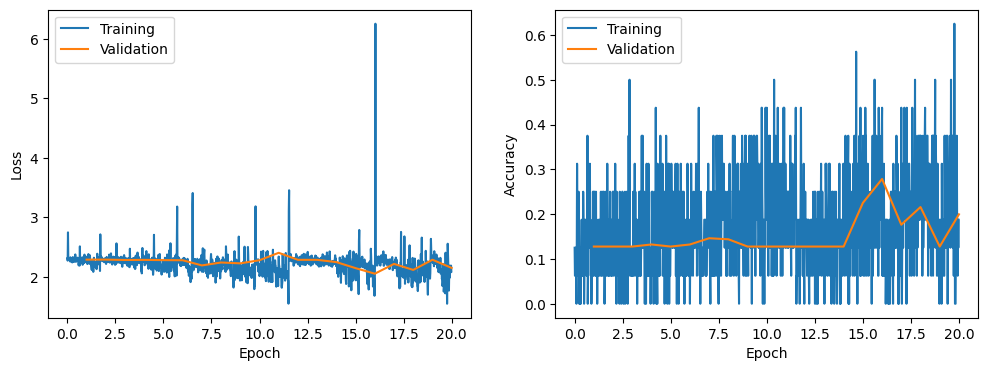

In [20]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history["epoch"], training_history["loss"], label="Training")
ax[0].plot(validation_history["epoch"], validation_history["loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(training_history["epoch"], training_history["accuracy"], label="Training")
ax[1].plot(
    validation_history["epoch"], validation_history["accuracy"], label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [21]:
# Get the validation accuracy of the best model
# Get the accuracy corresponding to the lowest loss
lowest_loss = validation_history['loss'].min()
best_accuracy = validation_history.loc[validation_history['loss'] == lowest_loss, 'accuracy'].item()
print(f'Best validation accuracy during training: {best_accuracy}')

Best validation accuracy during training: 0.27842227378190254


# Test Data Prediction: Custom Neural Network Model
Make Predictions for the Test Data. This function is already defined for you, you just need to call it and pass in the required parameters.

In [29]:
def generate_test_predictions(model, data_transforms, test_data_dir, output_csv_path, classes):
    # Create a DataLoader for the test dataset
    test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Load the pre-trained model
    model.eval()

    # Initialize lists to store filenames and predicted class labels
    filenames = []
    predicted_labels = []

    # Iterate through the test dataset and make predictions
    with torch.no_grad():
        for inputs, _ in test_loader:
            if (torch.cuda.is_available()):
                device = torch.device("cuda")
            elif (torch.mps.is_available()):
                device = torch.device('mps')
            else:
                device = torch.device("cpu")
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Convert integer labels to class names
            predicted_class_names = [classes[p] for p in predicted]

            # predicted class labels
            predicted_labels.extend(predicted_class_names)


    # Get the basenames of the files
    basenames = [os.path.basename(filename) for filename, _ in test_dataset.imgs]

    # Create a DataFrame to store basenames and predicted labels
    data = {'Basename': basenames, 'Predictions': predicted_labels}
    df = pd.DataFrame(data)

    # Sort the DataFrame by Basename
    df.sort_values(by='Basename', inplace=True)

    # drop the Basename column
    df.drop(columns=['Basename'], inplace=True)

    # Save the sorted predictions to a CSV file
    df.to_csv(output_csv_path, index=False)
    print(f'Predictions saved to {output_csv_path}')

In [30]:
# Generate test predictions and output the predictions to CSV named 'caltech256_custom_nn_prediction.csv'
generate_test_predictions(
    model = model,
    data_transforms = data_transforms,
    test_data_dir = './datasets/CalTech-256/test',
    output_csv_path = './caltech256_custom_nn_prediction.csv',
    classes = classes
)

Predictions saved to ./caltech256_custom_nn_prediction.csv


# Fine-Tune VGG16

Now, we will be fine-tuning a VGG16 model to perform the same CalTech-256 classification task and compare the performance against the custom model which is trained from scratch.

# Loading CalTech-256 training data from directory (VGG16)

1. Define Data Transforms:

  + Define data transformations using `transforms.Compose`. This should include
    + Padding to make the image a square.
    + Conversion to a tensor. Converts a PIL Image or numpy.ndarray (H x W x C) in the range `[0, 255]` to a torch.FloatTensor of shape (C x H x W) in the range `[0.0, 1.0]`.
    + Resizing to (224, 224).
    + Normalization using the mean and standard deviation values `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]`. These values are used for the pre-train ImageNet Dataset to set the values to be in the range `[-1, 1]`.
    + Optionally, you can include other preprocessing steps.
  + Padding is added to maintain the aspect ratio when resizing to (224, 224). The resizing to (224, 224) and normalization are performed to ensure that the images match the input shape of VGG16 in the later parts.

2. Load the CalTech-256 Dataset:

  + Set the path to your CalTech-256 `train` dataset directory.
  + Create the dataset using the `datasets.ImageFolder` class. This class automatically assigns labels based on the subdirectory names.

3. Get Class Labels:

  + Obtain the class labels (class names) from the `all_dataset.classes` attribute. This will give you a list of class labels in the order they appear in the dataset.

In [31]:
import torch
from torchvision import transforms, datasets

# Define the data transformations composing of ToTensor and
# - Padding to make the image a square
# - Conversion to a tensor
# - Resize to size (224, 224)
# - Normalization using the mean and standard deviation values
#  `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]`
# Compose: https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
data_transforms = transforms.Compose([
    transforms.Pad(32, fill=0, padding_mode='constant'),  # Add padding to make the image a square
    transforms.Resize((224, 224)),                      # Resize to match VGG16 input size
    transforms.ToTensor(),                              # Convert image to tensor with values in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # Normalize with ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])

# Create a dataset using ImageFolder
# ImageFolder: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
all_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Get the class labels
classes = all_dataset.classes
num_classes = len(classes)

print(f'Number of classes: {num_classes}')
print(f'Class labels: {classes}')

Number of classes: 10
Class labels: ['011.billiards', '092.grapes', '101.head-phones', '105.horse', '126.ladder', '138.mattress', '148.mussels', '159.people', '168.raccoon', '227.treadmill']


Split Dataset into training and validation

In [33]:
# random_split: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

dataset_size = len(all_dataset)

valid_size = int(valid_set_size*dataset_size)

train_size = dataset_size-valid_size

generator = torch.Generator().manual_seed(9)

train_dataset, val_dataset = torch.utils.data.random_split(all_dataset, [train_size, valid_size], generator=generator)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 1008
Validation dataset size: 431


Once arranged into a `Dataset`, we wrap the `Dataset` in a `Dataloader` object.

In [34]:
# DataLoader: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Overview of Fine-Tuning VGG16

VGG16 is a popular deep convolutional neural network architecture used for various computer vision tasks. It consists of two main components: the "features" part and the "classifier" part. Fine-tuning VGG16 involves adjusting these components to adapt the pre-trained model to a new task.

Components of VGG16
1. Features Layers:
The "features" part of VGG16 comprises a stack of convolutional and max-pooling layers. These layers serve as feature extractors and are responsible for capturing hierarchical features from the input image.
These layers are typically frozen during fine-tuning when using transfer learning. Freezing means that the weights of these layers are not updated during training to preserve the pre-trained knowledge.
2. Classifier Layers:
The "classifier" part of VGG16 consists of fully connected layers (also known as dense layers). These layers are responsible for making predictions based on the extracted features.
During fine-tuning, the classifier layers are often replaced by a new set of fully connected layers to adapt the model to the specific task.
---

Load the Pre-Trained VGG16 Model:

Begin by loading the pre-trained VGG16 model with weights 'IMAGENET1K_V1', which includes both the features and classifier components. You can do this using PyTorch's torchvision.models.

In [35]:
import torchvision.models as models

# load VGG16 models with weights 'IMAGENET1K_V1'
# CODE HERE
# Load VGG16 models with weights 'IMAGENET1K_V1'
model = models.vgg16(weights='IMAGENET1K_V1')


Freeze the Features Layers:

Disable gradient updates to prevent them from changing during training. This step ensures that the model retains its ability to extract relevant features from the data.

In [36]:
# Get the features part of the model
features = model.features# Provided

# Freeze the feature layers
# CODE HERE
for param in features.parameters():# Provided
    param.requires_grad = False# Provided END


Define and Replace the Classifier:


+ Replace only the last layer to have 10 output units for the CalTech-256 dataset. Note: Last classifier layer has 4096 input units.
+ Set the last layer to require gradients for fine-tuning.

In [37]:
# Modify the last layer to have 10 output units for the CalTech-256 dataset
# CODE HERE
num_classes = 10# Provided
model.classifier[6] = nn.Linear(4096, num_classes)# Provided

# Set the last layer to require gradients for fine-tuning
# CODE HERE
model.classifier[6].requires_grad = True# Provided END

# Fine-Tune VGG16 Model

In [38]:
# Create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
history: TrainValLossAcc = train_loop(model=model,optimizer=optimizer,train_data = train_dataloader,
                                      val_data = val_dataloader,
                                      num_epochs=num_epochs)


Training progress...: 100%|██████████| 20/20 [05:14<00:00, 15.74s/it]


We provide this visualization code, to give you a picture of what your model learned while it was training.

In [39]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields,
)
training_history["epoch"] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(history.val, columns=LossAcc._fields)
validation_history["epoch"] = validation_history.index + 1


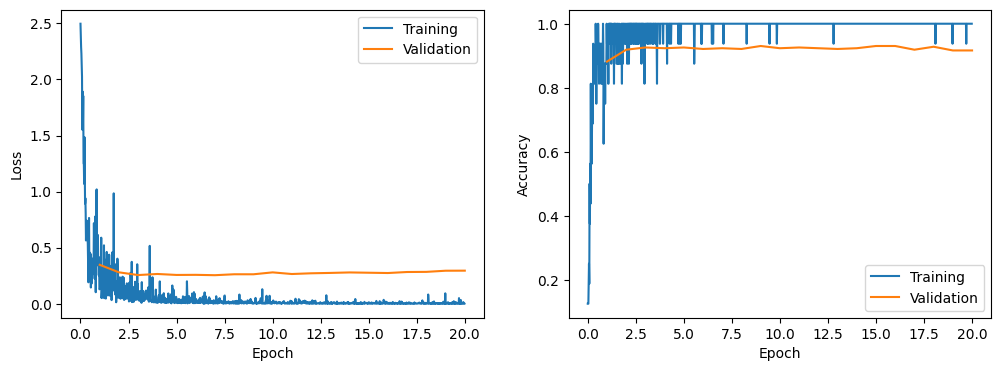

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history["epoch"], training_history["loss"], label="Training")
ax[0].plot(validation_history["epoch"], validation_history["loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(training_history["epoch"], training_history["accuracy"], label="Training")
ax[1].plot(
    validation_history["epoch"], validation_history["accuracy"], label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [41]:
# Get the validation accuracy of the best model
# Get the accuracy corresponding to the lowest loss
lowest_loss = validation_history['loss'].min()
best_accuracy = validation_history.loc[validation_history['loss'] == lowest_loss, 'accuracy'].item()
print(f'Best validation accuracy during training: {best_accuracy}')

Best validation accuracy during training: 0.9234338747099768


# Test Data Prediction: VGG16


In [44]:
# Generate test predictions and output the predictions to CSV named 'caltech256_custom_nn_prediction.csv'
generate_test_predictions(
    model = model,
    data_transforms = data_transforms,
    test_data_dir = './datasets/CalTech-256/test',
    output_csv_path = './caltech256_vgg16_nn_prediction.csv',
    classes = classes
)

Predictions saved to ./caltech256_vgg16_nn_prediction.csv
